In [41]:
from transformers import AutoImageProcessor, TimesformerForVideoClassification
import numpy as np
import torch

video = list(np.random.rand(8, 3, 224, 224))

processor = AutoImageProcessor.from_pretrained("facebook/timesformer-base-finetuned-k600")
model = TimesformerForVideoClassification.from_pretrained("facebook/timesformer-base-finetuned-k600")

inputs = processor(images=video, return_tensors="pt")

with torch.no_grad():
  outputs = model.timesformer(**inputs).last_hidden_state
  feature = outputs[:,1:].reshape(-1, 8, 14, 14, 768)

print(feature.shape)

torch.Size([1, 8, 14, 14, 768])


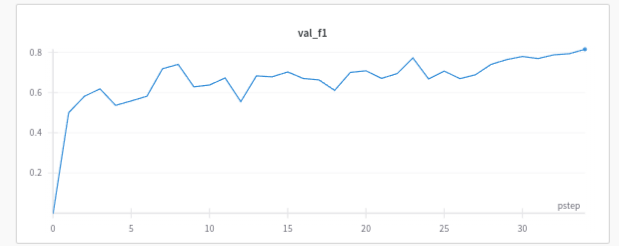